In [14]:
import os
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm

import random
import time
import csv

In [11]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True   # cho phép load ảnh lỗi 1 phần

class FaceDataset(Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        self.root_dir = root_dir
        self.annotations = pd.read_csv(os.path.join(root_dir, csv_file))
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        try:
            image = Image.open(img_path).convert("RGB")
        except (FileNotFoundError, OSError) as e:
            print(f"⚠️ Lỗi ảnh: {img_path}, bỏ qua.")
            return self.__getitem__((idx + 1) % len(self))  # lấy ảnh khác

        label = int(self.annotations.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        return image, label

In [12]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

# dataset 1
dataset1 = FaceDataset(root_dir="dataset_processed/photo", csv_file="list_filtered.csv", transform=transform)

# dataset 2
dataset2 = FaceDataset(root_dir="dataset_processed/photo2", csv_file="list_filtered.csv", transform=transform)

# gộp 2 dataset
full_dataset = torch.utils.data.ConcatDataset([dataset1, dataset2])

# ---- thử với 100 ảnh để test nhanh ----
# subset_size = 1000
# indices = list(range(subset_size))  # lấy 100 ảnh đầu tiên
# small_dataset = Subset(full_dataset, indices)

# chia train / test
train_size = int(0.8 * len(dataset1))
test_size = len(dataset1) - train_size
train_dataset, test_dataset = random_split(dataset1, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=True)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

Train samples: 3480, Test samples: 870


In [4]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 64 * 64, 128)
        self.fc2 = nn.Linear(128, 2)   # 2 lớp: live / not_live

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
# class SimpleCNN(nn.Module):
#     def __init__(self, example_input_hw=(256, 256)):  # đổi (128,128) nếu bạn resize
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 32, 3, 1, 1)
#         self.pool  = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)

#         self.features = nn.Sequential(
#             self.conv1, nn.ReLU(), self.pool,
#             self.conv2, nn.ReLU(), self.pool
#         )

#         # tính flatten tự động
#         with torch.no_grad():
#             h, w = example_input_hw
#             dummy = torch.zeros(1, 3, h, w)
#             out   = self.features(dummy)
#             flat  = out.numel()
#         self.fc1 = nn.Linear(flat, 128)
#         self.fc2 = nn.Linear(128, 2)

#     def forward(self, x):
#         x = self.features(x)
#         x = x.view(x.size(0), -1)
#         x = torch.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x


In [ ]:
torch.manual_seed(42); np.random.seed(42); random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

# (Tùy chọn) nếu mất cân bằng lớp:
# class_weights = torch.tensor([w0, w1], dtype=torch.float32, device=device)
# criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-6, verbose=True
)

use_cuda = torch.cuda.is_available()
scaler = torch.amp.GradScaler("cuda", enabled=use_cuda)

num_epochs = 30
patience, best_val, bad_epochs = 5, float("inf"), 0

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
precisions, recalls, f1_scores = [], [], []
lrs = []  # lưu learning rate mỗi epoch
best_acc = 0.0

history = []  # sẽ ghi ra CSV sau

print("🚀 Bắt đầu training!\n")
start_all = time.time()

for epoch in range(num_epochs):
    epoch_start = time.time()
    current_lr = optimizer.param_groups[0]["lr"]

    # -------- TRAIN --------
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"[{epoch+1}/{num_epochs}] Training", leave=False):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast("cuda", enabled=use_cuda):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_train_loss = running_loss / max(1, len(train_loader))
    train_acc = 100.0 * correct / max(1, total)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # -------- EVAL --------
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"[{epoch+1}/{num_epochs}] Validating", leave=False):
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            with torch.amp.autocast("cuda", enabled=use_cuda):
                outputs = model(images)
                loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / max(1, len(test_loader))
    val_acc = 100.0 * correct / max(1, total)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall    = recall_score(all_labels, all_preds, zero_division=0)
    f1        = f1_score(all_labels, all_preds, zero_division=0)
    precisions.append(precision); recalls.append(recall); f1_scores.append(f1)

    # Scheduler theo val_loss
    scheduler.step(avg_val_loss)
    lrs.append(current_lr)

    # ---- Print epoch summary ----
    epoch_time = time.time() - epoch_start
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"LR: {current_lr:.2e} | "
          f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
          f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, "
          f"Prec: {precision:.3f}, Rec: {recall:.3f}, F1: {f1:.3f} "
          f"| Time: {epoch_time:.1f}s")

    # Save best theo Val Acc (có thể đổi sang theo Val Loss tùy mục tiêu)
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "checkpoint/best_model_1.pth")
        print(f"✅ Saved new best model (Val Acc: {best_acc:.2f}%)")

    # Early stopping theo val_loss
    if avg_val_loss + 1e-6 < best_val:
        best_val = avg_val_loss
        bad_epochs = 0
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print(f"⏹️ Early stopping tại epoch {epoch+1} (no val_loss improvement for {patience} epochs)")
            break

    # --- lưu log cho epoch hiện tại (để ghi CSV) ---
    history.append({
        "epoch": epoch + 1,
        "lr": current_lr,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "train_acc": train_acc,
        "val_acc": val_acc,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "epoch_time_sec": epoch_time
    })

# ---- Save training log (CSV) ----
df = pd.DataFrame(history)
df.to_csv("training_log.csv", index=False)
print(f"\n📁 Đã lưu log {len(df)} epoch vào: training_log.csv")
print(f"⏱️ Tổng thời gian: {time.time() - start_all:.1f}s | 🏆 Best Val Acc: {best_acc:.2f}%")

d:\CODE\face-anti-spoofing\cv_env\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


🚀 Bắt đầu training!



Epoch [1/30] LR: 5.00e-04 | Train Loss: 0.2906, Val Loss: 0.2094, Train Acc: 88.42%, Val Acc: 93.22%, Prec: 0.957, Rec: 0.964, F1: 0.960 | Time: 94.4s
✅ Saved new best model (Val Acc: 93.22%)


Epoch [2/30] LR: 5.00e-04 | Train Loss: 0.2537, Val Loss: 0.2184, Train Acc: 91.06%, Val Acc: 92.76%, Prec: 0.951, Rec: 0.965, F1: 0.958 | Time: 58.0s


Epoch [3/30] LR: 5.00e-04 | Train Loss: 0.2290, Val Loss: 0.1629, Train Acc: 91.90%, Val Acc: 94.71%, Prec: 0.958, Rec: 0.981, F1: 0.969 | Time: 58.5s
✅ Saved new best model (Val Acc: 94.71%)


Epoch [4/30] LR: 5.00e-04 | Train Loss: 0.2289, Val Loss: 0.1832, Train Acc: 92.67%, Val Acc: 93.10%, Prec: 0.942, Rec: 0.980, F1: 0.960 | Time: 58.8s


Epoch [5/30] LR: 5.00e-04 | Train Loss: 0.2103, Val Loss: 0.2620, Train Acc: 92.87%, Val Acc: 91.15%, Prec: 0.906, Rec: 1.000, F1: 0.951 | Time: 61.3s


Epoch [6/30] LR: 5.00e-04 | Train Loss: 0.2050, Val Loss: 0.1774, Train Acc: 93.30%, Val Acc: 92.07%, Prec: 0.916, Rec: 0.999, F1: 0.956 | Time: 66.7s


Epoch [7/30] LR: 2.50e-04 | Train Loss: 0.1638, Val Loss: 0.1424, Train Acc: 94.25%, Val Acc: 96.09%, Prec: 0.981, Rec: 0.973, F1: 0.977 | Time: 61.1s
✅ Saved new best model (Val Acc: 96.09%)


Epoch [8/30] LR: 2.50e-04 | Train Loss: 0.1544, Val Loss: 0.1126, Train Acc: 94.40%, Val Acc: 96.67%, Prec: 0.980, Rec: 0.981, F1: 0.980 | Time: 99.6s
✅ Saved new best model (Val Acc: 96.67%)


Epoch [9/30] LR: 2.50e-04 | Train Loss: 0.1526, Val Loss: 0.1261, Train Acc: 94.63%, Val Acc: 96.32%, Prec: 0.986, Rec: 0.970, F1: 0.978 | Time: 69.0s


Epoch [10/30] LR: 2.50e-04 | Train Loss: 0.1396, Val Loss: 0.1377, Train Acc: 95.23%, Val Acc: 94.94%, Prec: 0.951, Rec: 0.992, F1: 0.971 | Time: 59.4s


Epoch [11/30] LR: 2.50e-04 | Train Loss: 0.1530, Val Loss: 0.1247, Train Acc: 94.83%, Val Acc: 95.75%, Prec: 0.966, Rec: 0.985, F1: 0.975 | Time: 61.1s


Epoch [12/30] LR: 1.25e-04 | Train Loss: 0.1445, Val Loss: 0.1152, Train Acc: 95.03%, Val Acc: 96.09%, Prec: 0.975, Rec: 0.980, F1: 0.977 | Time: 59.7s


Epoch [13/30] LR: 1.25e-04 | Train Loss: 0.1405, Val Loss: 0.1368, Train Acc: 95.20%, Val Acc: 95.75%, Prec: 0.978, Rec: 0.972, F1: 0.975 | Time: 59.3s
⏹️ Early stopping tại epoch 13 (no val_loss improvement for 5 epochs)

📁 Đã lưu log 12 epoch vào: training_log.csv
⏱️ Tổng thời gian: 868.1s | 🏆 Best Val Acc: 96.67%


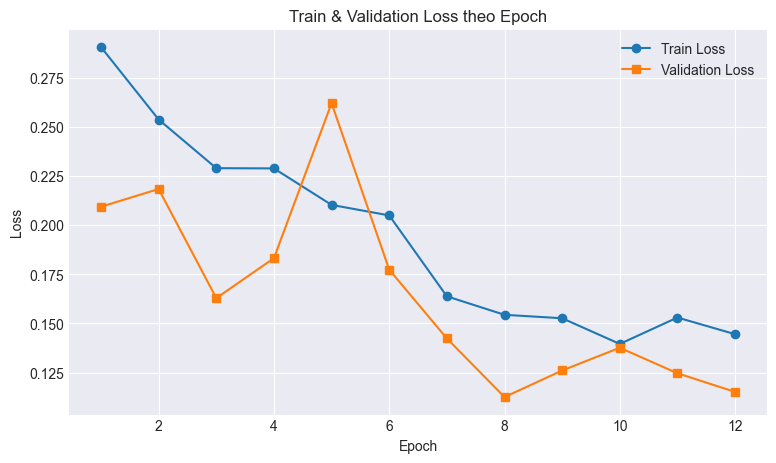

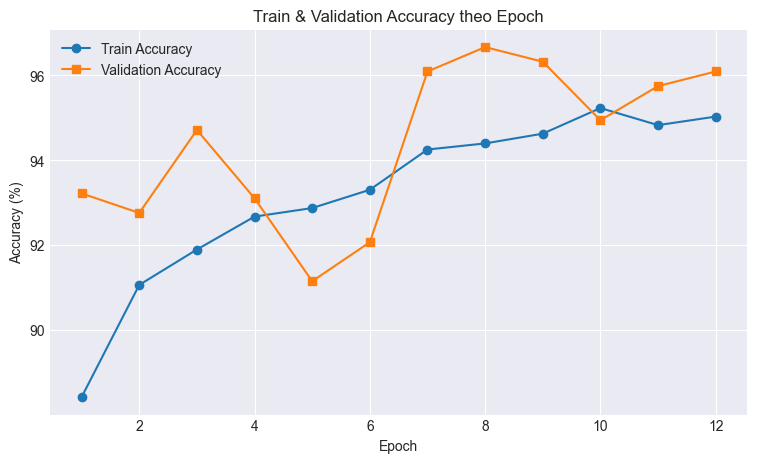

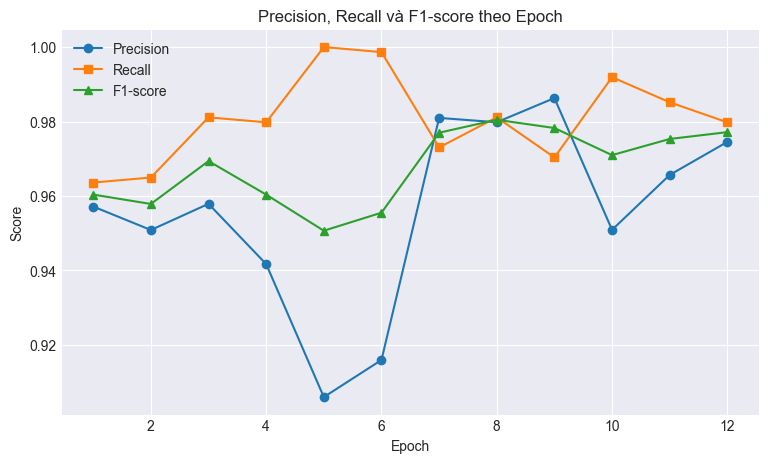

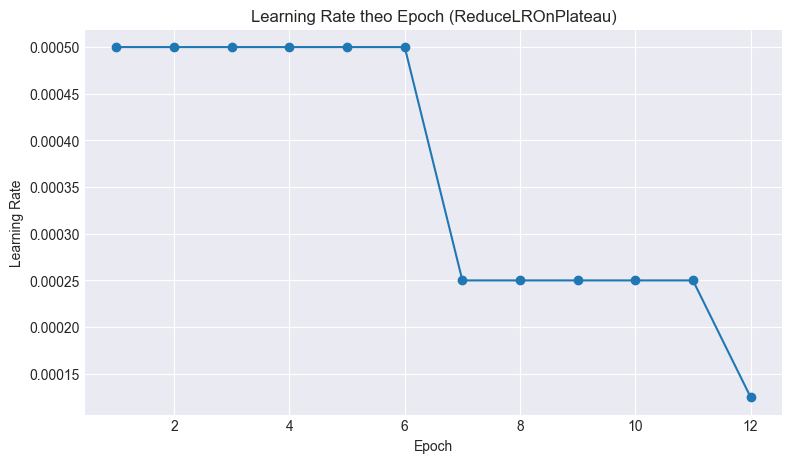

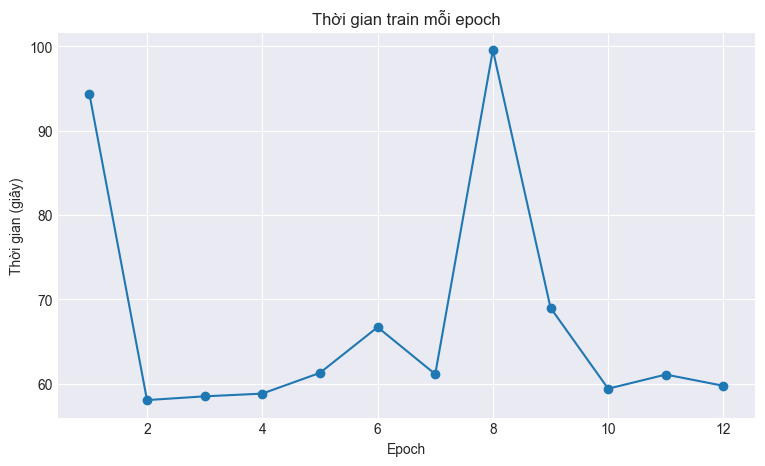

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# ---- Đọc file log ----
df = pd.read_csv("training_log.csv")

plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams["figure.figsize"] = (9, 5)

# ---- 1️⃣ Loss ----
plt.figure()
plt.plot(df["epoch"], df["train_loss"], marker="o", label="Train Loss")
plt.plot(df["epoch"], df["val_loss"], marker="s", label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Validation Loss theo Epoch")
plt.legend()
plt.show()

# ---- 2️⃣ Accuracy ----
plt.figure()
plt.plot(df["epoch"], df["train_acc"], marker="o", label="Train Accuracy")
plt.plot(df["epoch"], df["val_acc"], marker="s", label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Train & Validation Accuracy theo Epoch")
plt.legend()
plt.show()

# ---- 3️⃣ Precision / Recall / F1 ----
plt.figure()
plt.plot(df["epoch"], df["precision"], marker="o", label="Precision")
plt.plot(df["epoch"], df["recall"], marker="s", label="Recall")
plt.plot(df["epoch"], df["f1_score"], marker="^", label="F1-score")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Precision, Recall và F1-score theo Epoch")
plt.legend()
plt.show()

# ---- 4️⃣ Learning rate ----
if "lr" in df.columns:
    plt.figure()
    plt.plot(df["epoch"], df["lr"], marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rate theo Epoch (ReduceLROnPlateau)")
    plt.show()

# ---- 5️⃣ Thời gian mỗi epoch ----
if "epoch_time_sec" in df.columns:
    plt.figure()
    plt.plot(df["epoch"], df["epoch_time_sec"], marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Thời gian (giây)")
    plt.title("Thời gian train mỗi epoch")
    plt.show()


In [6]:
from PIL import Image

# Ánh xạ label -> tên class
classes = ["not_live", "live"]

def predict_image(img_path, model, transform, device="cpu"):
    model.eval()
    image = Image.open(img_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)  # thêm batch dim

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    return classes[predicted.item()]

C:\Users\Admin\AppData\Local\Temp\ipykernel_6608\3008250269.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("checkpoint/best_model_

Ảnh dataset_processed/photo2/live/pandaa.jpg được dự đoán là: live


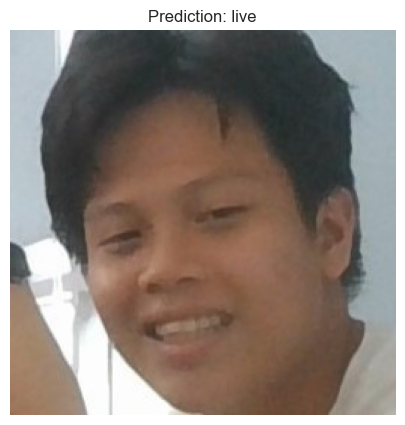

In [13]:
# Load lại best model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model = SimpleCNN().to(device)
best_model.load_state_dict(torch.load("checkpoint/best_model_1.pth"))
best_model.eval()
# print("Loaded best model with acc:", best_acc)

# Predict 1 ảnh bất kỳ
sample_img = "dataset_processed/photo2/live/pandaa.jpg"
result = predict_image(sample_img, best_model, transform, device)
print(f"Ảnh {sample_img} được dự đoán là: {result}")

import matplotlib.pyplot as plt

img = Image.open(sample_img).convert("RGB")
plt.imshow(img)
plt.title(f"Prediction: {result}")
plt.axis("off")
plt.show()